In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import logging

from src.plot_data import PlotPumpData
from sklearn.preprocessing import StandardScaler
import plotly.io as pio

#plt.style.use('dark_background')
plt.style.use('classic')
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
from sklearn.preprocessing import StandardScaler

speed_scaler = StandardScaler()
outflow_scaler = StandardScaler()
power_scaler = StandardScaler()


# Loading Dataframe and applying the filter

In [3]:
from src.preprocessing_module import Preprocessig_Toolbox
from src.filter_module import DataFilter

#set the size od the data frame to import and the dataframe path
DATAFRAME_SIZE = .31
DATAFRAME_PATH = "/home/alqua/Data/revpi_borholm_raw_data_until_march.pickle"

processing = Preprocessig_Toolbox(dataframe_size = DATAFRAME_SIZE, dataframe_path= DATAFRAME_PATH)
filter = DataFilter(forward_stability_condition = 3)
#df_filtered = filter.fit_transform(processing.data)
#df_filtered.to_pickle("./data/filtered_dataset_sample.pickle")
df_filtered = pd.read_pickle("data/filtered_dataset_sample.pickle")
logging.info("Dataframe cleaned and saved in ./data")



INFO:root:loading data...


INFO:root:Dataframe cleaned and saved in ./data


In [28]:
df_filtered.head(5)

,height,inflow,outflow,pump1_rpm,pump1_power,pump4_rpm,pump4_power,wref,time_delta_sec
time,,,,,,,,,
2022-11-29 13:16:32.234310+00:00,156.0,0.076423,0.002778,197.0,26.385000,270.5,13.695,92.4,7.565058
2022-11-29 13:17:11.176855+00:00,158.0,0.068736,0.049167,960.0,36.505001,0.0,0.000,93.2,20.548744
2022-11-29 13:18:25.788610+00:00,159.0,0.070290,0.068889,1020.0,39.869999,0.0,0.000,93.6,24.871843
2022-11-29 13:18:51.742300+00:00,160.0,0.075029,0.075278,1050.0,40.990002,0.0,0.000,94.0,84.369488
2022-11-29 13:20:23.675391+00:00,161.0,0.081768,0.082500,1080.0,43.035000,0.0,0.000,94.4,64.910178


In [5]:
df_filtered["pump1_rpm"] = df_filtered["pump1_rpm"].abs()
df_filtered["pump4_rpm"] = df_filtered["pump4_rpm"].abs()
df_filtered["outflow"] = df_filtered["outflow"]/3600
df_filtered["inflow"] = df_filtered["inflow"]/3600

df_filtered = df_filtered.set_index("time")

df_p1 = df_filtered[(df_filtered["pump1_rpm"] > 0) & (df_filtered["pump4_rpm"] == 0)]
df_p4 = df_filtered[(df_filtered["pump4_rpm"] > 0) & (df_filtered["pump1_rpm"] == 0)]

In [6]:
speed_scaler.fit(pd.concat([df_p1["pump1_rpm"], df_p4["pump4_rpm"]]).to_numpy().reshape(-1, 1))
power_scaler.fit(pd.concat([df_p1["pump1_power"], df_p4["pump4_power"]]).to_numpy().reshape(-1, 1))
outflow_scaler.fit(pd.concat([df_p1["outflow"], df_p4["outflow"]]).to_numpy().reshape(-1, 1))


StandardScaler()

In [7]:
from pickle import dump

dump(speed_scaler, open('data/models/speed_scaler.pkl', 'wb'))
dump(power_scaler, open('data/models/power_scaler.pkl', 'wb'))
dump(outflow_scaler, open('data/models/outflow_scaler.pkl', 'wb'))

In [8]:
df_p1 = df_p1[df_p1["pump1_rpm"] > 200]
df_p4 = df_p4[df_p4["pump4_rpm"] > 200]

In [9]:
df_p1["pump1_rpm"]   = speed_scaler.transform(df_p1["pump1_rpm"].to_numpy().reshape(-1, 1))
df_p1["pump1_power"] =   power_scaler.transform(df_p1["pump1_power"].to_numpy().reshape(-1, 1))
df_p1["outflow"]     =   outflow_scaler.transform(df_p1["outflow"].to_numpy().reshape(-1, 1))

df_p4["pump4_rpm"]   = speed_scaler.transform(df_p4["pump4_rpm"].to_numpy().reshape(-1, 1))
df_p4["pump4_power"] = power_scaler.transform(df_p4["pump4_power"].to_numpy().reshape(-1, 1))
df_p4["outflow"]     = outflow_scaler.transform(df_p4["outflow"].to_numpy().reshape(-1, 1))


## Speed vs Power Model


In [10]:
from src.power_regression_model_update import PowerQuadraticRegression, regression_metrics

### Pump 1

fitting new module
The R squared of the regression model for pump1 is: 0.9854.
The MSE of the regression model for pump1 is: 0.0164.


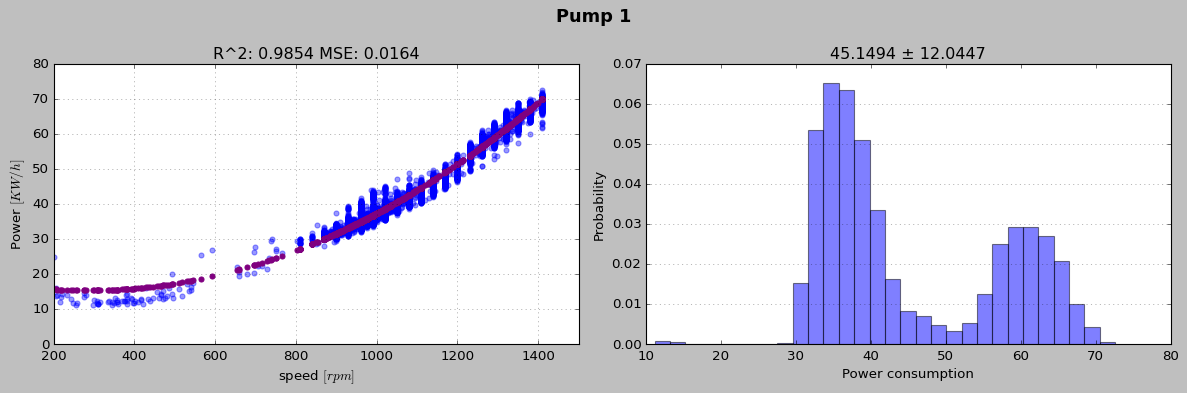

In [11]:
power_model_p1 = PowerQuadraticRegression()
power_model_p1.fit(df_p1["pump1_rpm"], df_p1["pump1_power"], 2)
power_model_p1.save("data/models/speed_power_p1")

power_pred_p1 = power_model_p1.predict(df_p1["pump1_rpm"])
r_squared_p1, mse_power_p1 =  regression_metrics(df_p1["pump1_power"],power_pred_p1)
print(f'The R squared of the regression model for pump1 is: {r_squared_p1:.4f}.') 
print(f'The MSE of the regression model for pump1 is: {mse_power_p1:.4f}.') 

speed_power_plot_p1 = PlotPumpData(x = speed_scaler.inverse_transform(df_p1["pump1_rpm"].to_numpy().reshape(-1, 1)), y = power_scaler.inverse_transform(df_p1["pump1_power"].to_numpy().reshape(-1, 1)), 
                       num_bins = 30,
                       r_squared = r_squared_p1,
                       mse = mse_power_p1,
                       predictions = power_scaler.inverse_transform((power_pred_p1.reshape(-1, 1))),
                       lower_bound=200,
                       upper_bound=1500, 
                       title = 'Pump 1', 
                       x_label_plt1= "speed $[rpm]$", y_label_plt1="Power " + r"$[KW/h]$", 
                       x_label_plt2= "Power consumption", y_label_plt2="Probability")

speed_power_plot_p1.plot_data()

## Pump4 Model

fitting new module
The R squared of the regression model for pump4 is: 0.9841.
The MSE of the regression model for pump4 is: 0.0137.


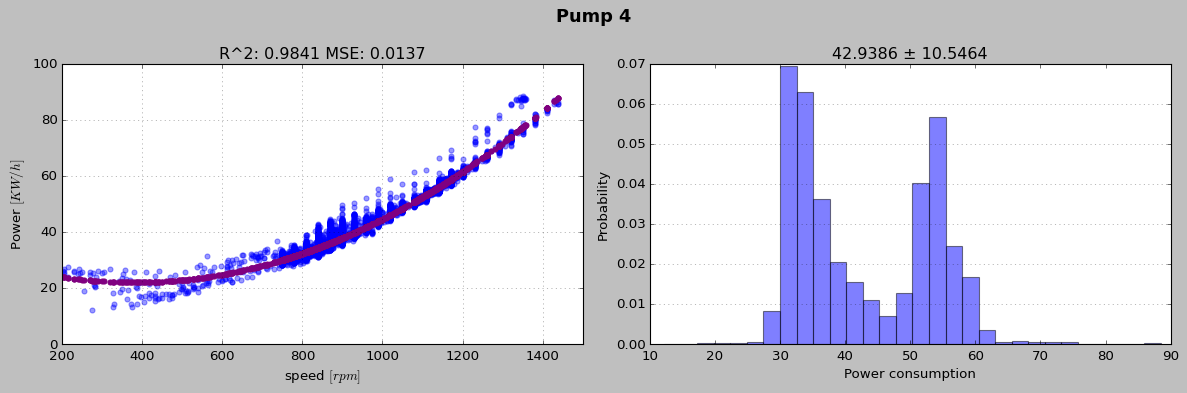

In [12]:
power_model_p4 = PowerQuadraticRegression()
power_model_p4.fit(df_p4["pump4_rpm"], df_p4["pump4_power"], 2)
power_model_p4.save("data/models/speed_power_p4")

power_pred_p4 = power_model_p4.predict(df_p4["pump4_rpm"])
r_squared_p4, mse_power_p4 =  regression_metrics(df_p4["pump4_power"],power_pred_p4)
print(f'The R squared of the regression model for pump4 is: {r_squared_p4:.4f}.') 
print(f'The MSE of the regression model for pump4 is: {mse_power_p4:.4f}.') 

speed_power_plot_p4 = PlotPumpData(x = speed_scaler.inverse_transform(df_p4["pump4_rpm"].to_numpy().reshape(-1, 1)), y = power_scaler.inverse_transform(df_p4["pump4_power"].to_numpy().reshape(-1, 1)), 
                       num_bins = 30,
                       r_squared = r_squared_p4,
                       mse = mse_power_p4,
                       predictions = power_scaler.inverse_transform((power_pred_p4.reshape(-1, 1))),
                        lower_bound=200,
                       upper_bound=1500, 
                       title = 'Pump 4', 
                       x_label_plt1= "speed $[rpm]$", y_label_plt1="Power " + r"$[KW/h]$", 
                       x_label_plt2= "Power consumption", y_label_plt2="Probability")

speed_power_plot_p4.plot_data()

## Speed vs Outflow

In [13]:
from src.speed_outflow_regression_module_update import LinearFunctionRegression

### Pump 1

The R squared of the regression model for pump1 is: 0.736811
The MSE of the regression model for pump1 is: 0.164658


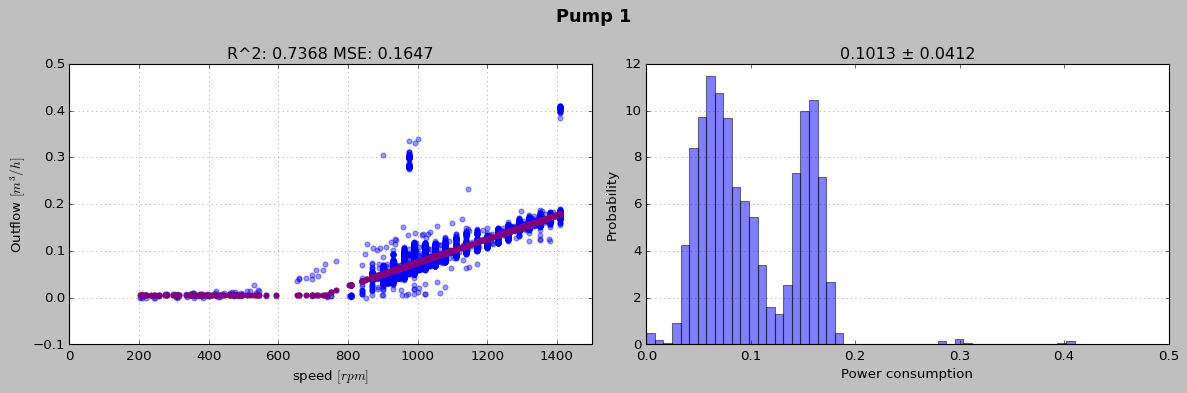

In [14]:
outflow_model_p1 = LinearFunctionRegression()
BREAKPOINT_P1 = 750
outflow_model_p1.fit(df_p1["pump1_rpm"], df_p1["outflow"],speed_scaler.transform(np.array(BREAKPOINT_P1).reshape(1, -1))[0,0])
BREAKPOINT_P1 = 750
outflow_model_p1.save("data/models/piecewise_linear_model_speed_outflow_p1", BREAKPOINT_P1)
outflow_pred_p1 = outflow_model_p1.predict(df_p1["pump1_rpm"])
r_squared_outflow_p1, mse_power_outflow_p1 =  regression_metrics(df_p1["outflow"],outflow_pred_p1)
print(f'The R squared of the regression model for pump1 is: {r_squared_outflow_p1:.6f}') 
print(f'The MSE of the regression model for pump1 is: {mse_power_outflow_p1:.6f}')

speed_outflow_plot_p1 = PlotPumpData(x = speed_scaler.inverse_transform(df_p1["pump1_rpm"].to_numpy().reshape(-1, 1)), y = outflow_scaler.inverse_transform(df_p1["outflow"].to_numpy().reshape(-1, 1)), 
                       num_bins = 50,
                       r_squared = r_squared_outflow_p1,
                       mse = mse_power_outflow_p1,
                       predictions = outflow_scaler.inverse_transform(outflow_pred_p1.reshape(-1, 1)),
                       lower_bound=0, 
                       upper_bound=1500,
                       title = 'Pump 1', 
                       x_label_plt1= "speed $[rpm]$", y_label_plt1="Outflow " + r"$[m^3/h]$", 
                       x_label_plt2= "Power consumption", y_label_plt2="Probability")
                    

speed_outflow_plot_p1.plot_data()

### Pump 4

The R squared of the regression model for pump1 is: 0.811227
The MSE of the regression model for pump1 is: 0.042583


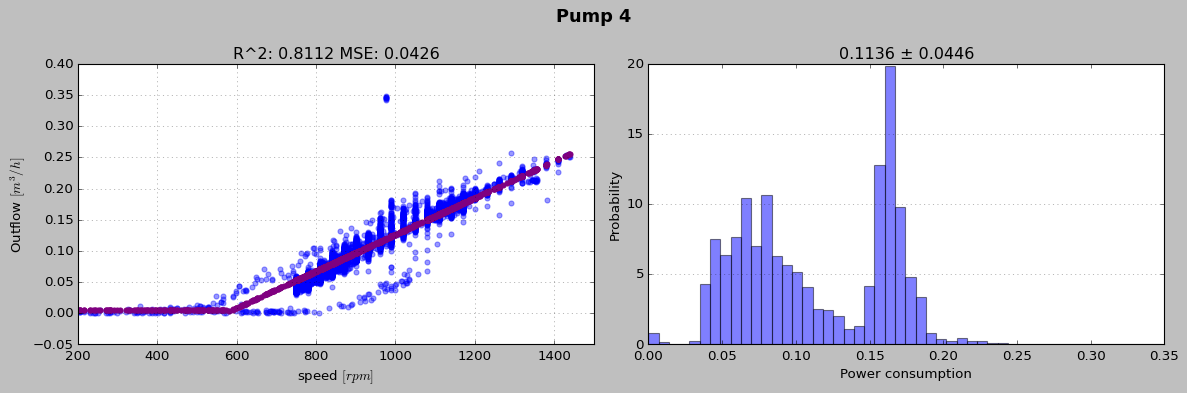

In [15]:
outflow_model_p4 = LinearFunctionRegression()
BREAKPOINT_P4 = 580
outflow_model_p4.fit(df_p4["pump4_rpm"], df_p4["outflow"],speed_scaler.transform(np.array(BREAKPOINT_P4).reshape(1, -1))[0,0])
outflow_model_p4.save("data/models/piecewise_linear_model_speed_outflow_p4", BREAKPOINT_P4)
outflow_pred_p4 = outflow_model_p4.predict(df_p4["pump4_rpm"])
r_squared_outflow_p4, mse_power_outflow_p4 =  regression_metrics(df_p4["outflow"],outflow_pred_p4)
print(f'The R squared of the regression model for pump1 is: {r_squared_outflow_p4:.6f}') 
print(f'The MSE of the regression model for pump1 is: {mse_power_outflow_p4:.6f}')

speed_outflow_plot_p4 = PlotPumpData(x = speed_scaler.inverse_transform(df_p4["pump4_rpm"].to_numpy().reshape(-1, 1)), y = outflow_scaler.inverse_transform(df_p4["outflow"].to_numpy().reshape(-1, 1)), 
                       num_bins = 50,
                       r_squared = r_squared_outflow_p4,
                       mse = mse_power_outflow_p4,
                       predictions = outflow_scaler.inverse_transform(outflow_pred_p4.reshape(-1, 1)),
                       lower_bound=200, 
                       upper_bound=1500,
                       title = 'Pump 4', 
                        x_label_plt1= "speed $[rpm]$", y_label_plt1="Outflow " + r"$[m^3/h]$", 
                       x_label_plt2= "Power consumption", y_label_plt2="Probability")

speed_outflow_plot_p4.plot_data()

# Model Validation

In [16]:
import os 
import pandas as pd
import numpy as np 
import logging
import pickle 
import random
#import the speed vs power model
from src.power_regression_model_update import PowerQuadraticRegression
#import speed vs outflow model 
from src.speed_outflow_regression_module_update import LinearFunctionRegression
#import inflow estimation module
from src.inflow_estimation_module import InflowOutflowModel
#import height validation model (only for validating the digital twin model)
from src.height_estimation_module import EMAInflowOutflowModel
#import the filter module
from src.filter_module import DataFilter
#import the preprocessing toolbox to apply the filter
from src.preprocessing_module import Preprocessig_Toolbox
#import function from the funcs file
from src.funcs import load_dataset, load_surrogate_model
#import the Digital Twin Simulation Block
pd.options.mode.chained_assignment = None  # default='warn'

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
df = pd.read_pickle("/home/alqua/Data/revpi_borholm_raw_data_until_march_with_inflow.pickle")

In [18]:
df = df[['time', 'height', 'inflow', 'outflow',
       'pump1_rpm', 'pump1_power', 
       'pump4_rpm', 'pump4_power']]

In [19]:
from src.inflow_estimation_module import InflowOutflowModel

In [20]:
df["inflow"]= df["inflow"]/3600
df["outflow"]= df["outflow"]/3600
df["height"] = df["height"]/100

In [21]:
random.seed(15785)

In [22]:
df_val = df[(df["time"] > "01/02/2023") & (df["time"] < "03/02/2023")]
df_val= df_val.reset_index(drop=True)

In [29]:
df_val.head(5)

,time,height,inflow,outflow,pump1_rpm,pump1_power,pump4_rpm,pump4_power
0,2023-01-03 14:19:02.455000+00:00,1.66,0.132500,0.132500,1230.0,53.89,0.0,0.0
1,2023-01-03 14:19:03.425000+00:00,1.66,0.131944,0.131944,1230.0,53.11,0.0,0.0
2,2023-01-03 14:19:04.425000+00:00,1.66,0.131111,0.131111,1230.0,52.70,0.0,0.0
3,2023-01-03 14:19:05.425000+00:00,1.66,0.131111,0.131111,1230.0,54.26,0.0,0.0
4,2023-01-03 14:19:06.425000+00:00,1.66,0.131667,0.131667,1230.0,51.19,0.0,0.0


In [24]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

with open('data/models/scaler_X_mpc_surrogate.pkl', 'rb') as f:
    scaler_X = pickle.load(f)

with open( 'data/models/scaler_Y_mpc_surrogate.pkl', 'rb') as g:
    scaler_Y = pickle.load(g)

/home/alqua/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
from src.inflow_estimation_module import InflowOutflowModel

inflow_model = InflowOutflowModel(window_size=5, area=20)
eff_list, result_df_list = [], []
counter = 0
STEPS = 500

for df in [df_val]:
    df = df[:STEPS]
    df = df.reset_index(drop=True)
    df = inflow_model.fit(df)
    
    w1_weight, w4_weight = 1,0
    Area = 20

    Start = True
    optimal_speeds_model = tf.keras.models.load_model('data/models/mpc_surrogate.h5')
    w1_old_history, w1_new_history = [],[]
    w4_old_history, w4_new_history = [],[]
    h_old_history, h_new_history = [],[]
    p1_old_history, p4_old_history = [],[]
    p1_new_history, p4_new_history = [],[]
    inflow_history, outflow_old_history, outflow_new_history = [], [], []
    simulated_heights_ema = []
    timestamp = []

    for index, _ in (df[1:STEPS].iterrows()):
        if Start:
            h = df.loc[index, "height"]
            simulated_heights_ema.append(df.loc[index, "height"])
            Start = False

        timestamp.append(df.loc[index, "time"])
        #smoothin inflow
        X_scaled = scaler_X.transform([[df.loc[index, "smoothed_inflow"] * 3600, h]])
        #predict best values of w1 and w4
        y_pred_scaled = optimal_speeds_model.predict(X_scaled, verbose=0)
        # retrieve the values from array
        #w1, w4 = scaler_Y.inverse_transform(y_pred_scaled)[0,0], scaler_Y.inverse_transform(y_pred_scaled)[0,1]
        w1 = df.loc[index, "pump1_rpm"]
        w4 = df.loc[index, "pump4_rpm"]
    

        w1_new_history.append(w1*w1_weight)
        w4_new_history.append(w4*w4_weight)
        w1_old_history.append(df.loc[index, "pump1_rpm"])
        w4_old_history.append(df.loc[index, "pump4_rpm"])

        
        outflow_pred_p1 = outflow_model_p1.predict(speed_scaler.transform(w1.reshape(1, -1))[0,0])
        outflow_pred_p1 = outflow_scaler.inverse_transform(outflow_pred_p1.reshape(1, -1))[0,0]
        outflow_pred_p4 = outflow_model_p4.predict(speed_scaler.transform(w4.reshape(1, -1))[0,0])
        outflow_pred_p4 = outflow_scaler.inverse_transform(outflow_pred_p4.reshape(1, -1))[0,0]

        total_outflow = outflow_pred_p1*w1_weight + outflow_pred_p4*w4_weight

        outflow_old_history.append(df.loc[index, "outflow"])
        outflow_new_history.append(total_outflow)

        p1_old_history.append(df.loc[index, "pump1_power"])
        p4_old_history.append(df.loc[index, "pump4_power"])

        p1_new_history.append(power_scaler.inverse_transform(power_model_p1.predict(speed_scaler.transform(w1.reshape(1, -1))[0,0]).reshape(1, -1))[0,0]*w1_weight)
        p4_new_history.append(power_scaler.inverse_transform(power_model_p4.predict(speed_scaler.transform(w4.reshape(1, -1))[0,0]).reshape(1, -1))[0,0]*w4_weight)

        inflow_history.append(df.loc[index, "inflow"])
        h_old_history.append(df.loc[index, "height"])

        time_diff = (df.loc[index, "time"] - df.loc[index - 1, "time"])
        time_diff_seconds = time_diff.total_seconds()
        net_volume_change = (df.loc[index, "inflow"] - (total_outflow)) * time_diff_seconds
        height_change = net_volume_change / Area
        h = simulated_heights_ema[-1] + height_change
        simulated_heights_ema.append(h)
        h_new_history.append(h)
        
    
    res = { "time": timestamp, 
            "inflow": inflow_history,
            "height": h_old_history,
            "height_opt": np.round(h_new_history,2),
            "outflow": np.round(outflow_old_history,2),
            "outflow_opt":np.round(outflow_new_history, 2),
            "pump1_rpm":w1_old_history,
            "pump1_rpm_opt": np.array(w1_new_history).astype(int), 
            "pump4_rpm": w4_old_history, 
            "pump4_rpm_opt": np.array(w4_new_history).astype(int),
            "pump1_power": p1_old_history,
            "pump1_power_opt": np.round(p1_new_history,2),
            "pump4_power": p4_old_history,
            "pump4_power_opt": np.round(p4_new_history,2)}
    
    result_df = pd.DataFrame(res)  
    result_df['time_seconds'] = (result_df['time'] - result_df['time'].iloc[0]).dt.total_seconds()
    outflow_per_unit_power_old = np.trapz(result_df['outflow'], x=result_df['time_seconds']) / (np.trapz(result_df['pump4_power'], x=result_df['time_seconds'])+ np.trapz(result_df['pump1_power'],x=result_df['time_seconds']))
    outflow_per_unit_power_new = np.trapz(result_df['outflow_opt'], x=result_df['time_seconds']) / (np.trapz(result_df['pump4_power_opt'], x=result_df['time_seconds'])+ np.trapz(result_df['pump1_power_opt'],x=result_df['time_seconds']))
    outflow_ratio = np.trapz(result_df['outflow_opt'], x=result_df['time_seconds'])/np.trapz(result_df['outflow'], x=result_df['time_seconds'])
    if (outflow_ratio <= 1.2) & (outflow_ratio >= 0.8):
        eff = ((outflow_per_unit_power_new - outflow_per_unit_power_old)/outflow_per_unit_power_old)*100
        print(eff)
        print(result_df["height_opt"].iloc[-1])
        eff_list.append(eff) 
        result_df_list.append(result_df)

100%|██████████| 499/499 [00:00<00:00, 29449.24it/s]


-1.6934879786409316
1.62


In [26]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 1
fs = 1    # sample rate, Hz
cutoff = .1  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

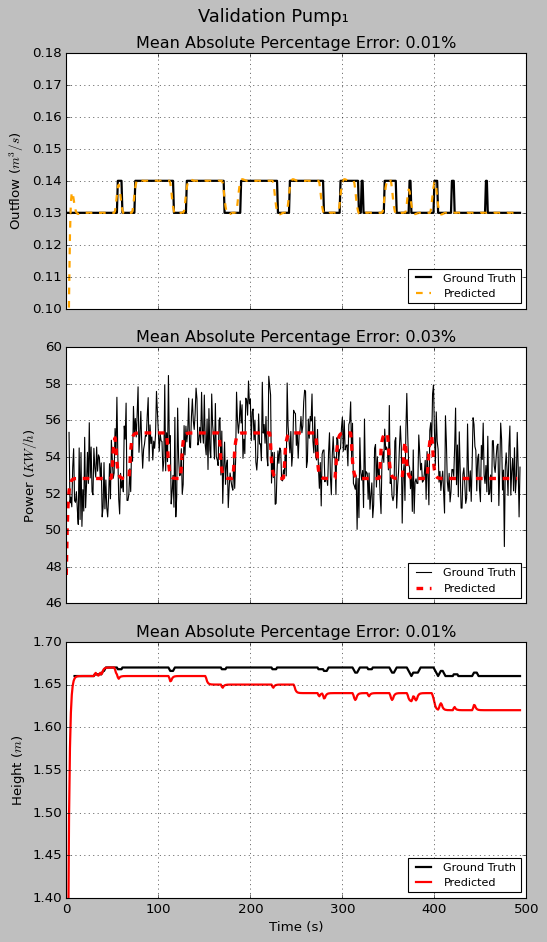

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

fig, axs = plt.subplots(3, 1, figsize=(7, 12), sharex=True)  # Set sharex=True to share x-axis

# First plot
axs[0].plot(result_df["outflow"], linewidth=2, color="black", label='Ground Truth')
axs[0].plot(butter_lowpass_filter(result_df["outflow_opt"], cutoff=.1, fs=1, order=2), linewidth=2, linestyle="dashed", color="orange", label='Predicted')
axs[0].grid()
axs[0].set_ylim(0.10, 0.18)
axs[0].set_ylabel('Outflow ($m^3/s$)')
axs[0].legend(loc='lower right', fontsize=10)
mean_percentage_error_outflow = mean_absolute_percentage_error(result_df["outflow"], result_df["outflow_opt"])
axs[0].set_title(f'Mean Absolute Percentage Error: {mean_percentage_error_outflow:.2f}%')

# Second plot
axs[1].plot(result_df["pump1_power"][3:], linewidth=1, color="black", label='Ground Truth')
axs[1].plot(butter_lowpass_filter(result_df["pump1_power_opt"]-1, cutoff=.1, fs=1, order=1)[3:], linewidth=3, linestyle="dashed", color="red", label='Predicted')
axs[1].grid()
axs[1].set_ylim(46, 60)
axs[1].set_ylabel('Power ($KW/h$)')
axs[1].legend(loc='lower right', fontsize=10)
mean_percentage_error_power = mean_absolute_percentage_error(result_df["pump1_power"], result_df["pump1_power_opt"])
axs[1].set_title(f'Mean Absolute Percentage Error: {mean_percentage_error_power:.2f}%')

# Third plot
axs[2].plot(result_df["height"][5:1000].rolling(5).mean(), linewidth=2, color="black", label='Ground Truth')
axs[2].plot(butter_lowpass_filter(result_df["height_opt"], cutoff=.1, fs=1, order=1), linewidth=2, color="red", label='Predicted')
axs[2].grid()
axs[2].set_ylim(1.4, 1.7)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Height ($m$)')
axs[2].legend(loc='lower right', fontsize=10)
mean_percentage_error_height = mean_absolute_percentage_error(result_df["height"], result_df["height_opt"])
axs[2].set_title(f'Mean Absolute Percentage Error: {mean_percentage_error_height:.2f}%')

plt.suptitle('Validation Pump₁', fontsize=16)
plt.tight_layout()
plt.show()